In [1]:
import pandas as pd
from feature_engenieering import feature_engineering

In [2]:
df = pd.read_csv('data/miami-housing.csv')

In [3]:
data_model = feature_engineering(df)

Registros antes de remover quality 3: 13932
Registros após remover quality 3: 13916
Registros removidos: 16

=== Feature Engineering Concluído ===
Shape final: (13916, 13)

Features finais:
['CNTR_DIST', 'age', 'avno60plus', 'log_sale_prc', 'log_lnd_sqfoot', 'log_tot_lvg_area', 'log_spec_feat_val', 'ocean_rank_2', 'ocean_rank_3', 'critical_month', 'quality_2', 'quality_4', 'quality_5']


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score,cross_val_predict
import numpy as np

In [5]:
X = data_model.drop('log_sale_prc', axis=1)
y = data_model['log_sale_prc']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
num_cols = ['CNTR_DIST', 'age', 'log_lnd_sqfoot', 'log_tot_lvg_area', 'log_spec_feat_val']

# Modelo Dummy

In [8]:
from sklearn.dummy import DummyRegressor

In [40]:

dummy = Pipeline([
        ('dummy', DummyRegressor(
            strategy='median'
        )),
    
])

In [41]:
# Usar cross_val_score para obter RMSE de cada fold
cv_scores = cross_val_score(dummy, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calcular RMSE em escala log para cada fold
rmse_log_scores = np.sqrt(-cv_scores)
# Calcular erro percentual para cada fold
error_percent_scores = (np.exp(rmse_log_scores) - 1) * 100

# Mostrar resultados de cada fold
print("--- Resultados por Fold ---\n")
for i, (rmse_log, err_pct) in enumerate(zip(rmse_log_scores, error_percent_scores), 1):
    print(f"Fold {i}:")
    print(f"  RMSE (log): {rmse_log:.4f}")
    print(f"  Erro Percentual: {err_pct:.2f}%")
    print()

# Calcular estatísticas agregadas
rmse_log_mean = rmse_log_scores.mean()
rmse_log_std = rmse_log_scores.std()
error_percent_mean = error_percent_scores.mean()
error_percent_std = error_percent_scores.std()

print("--- Média dos 5 Folds ---\n")
print(f"RMSE (log): {rmse_log_mean:.4f} ± {rmse_log_std:.4f}")
print(f"Erro Percentual: {error_percent_mean:.2f}% ± {error_percent_std:.2f}%")

--- Resultados por Fold ---

Fold 1:
  RMSE (log): 0.5548
  Erro Percentual: 74.16%

Fold 2:
  RMSE (log): 0.5816
  Erro Percentual: 78.89%

Fold 3:
  RMSE (log): 0.5780
  Erro Percentual: 78.24%

Fold 4:
  RMSE (log): 0.5558
  Erro Percentual: 74.34%

Fold 5:
  RMSE (log): 0.5603
  Erro Percentual: 75.13%

--- Média dos 5 Folds ---

RMSE (log): 0.5661 ± 0.0114
Erro Percentual: 76.15% ± 2.01%


Nosso modelo dummy performa muito mal como podemos ver. Mas vamos usar ele como baseline para comparação com os outros modelos 

# Modelo de Regressão Linear

In [15]:
from sklearn.linear_model import LinearRegression

In [17]:
numeric_pipeline_dummy = Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline_dummy,      num_cols),
],
remainder='passthrough')

linear_model = Pipeline([
    ('prepoc',preprocessor),
        ('linear', LinearRegression()),
    
])

In [18]:
from sklearn.model_selection import GridSearchCV

In [19]:
# Definir o grid de hiperparâmetros
param_grid = {
    'prepoc__num__poly__degree': [1, 2, 3],

}


In [20]:
# Executar Grid Search com validação cruzada
grid_search = GridSearchCV(
    estimator=linear_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Treinar
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ........................prepoc__num__poly__degree=1; total time=   0.0s
[CV] END ........................prepoc__num__poly__degree=1; total time=   0.0s
[CV] END ........................prepoc__num__poly__degree=1; total time=   0.0s
[CV] END ........................prepoc__num__poly__degree=1; total time=   0.0s
[CV] END ........................prepoc__num__poly__degree=1; total time=   0.0s
[CV] END ........................prepoc__num__poly__degree=2; total time=   0.0s
[CV] END ........................prepoc__num__poly__degree=2; total time=   0.1s
[CV] END ........................prepoc__num__poly__degree=2; total time=   0.1s
[CV] END ........................prepoc__num__poly__degree=2; total time=   0.0s
[CV] END ........................prepoc__num__poly__degree=2; total time=   0.0s
[CV] END ........................prepoc__num__poly__degree=3; total time=   0.1s
[CV] END ........................prepoc__num__pol

/Users/jgfaraco/miniconda3/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prepoc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('poly',
                                                                                          PolynomialFeatures(include_bias=False))]),
                                                                         ['CNTR_DIST',
                                                                          'age',
                                                                          'log_lnd_sqfoot',
                                                                          'log_tot_lvg_area',
                                                                          'log_spec_feat_val'])])),
                                       ('linear', LinearRegression())]),
             n_jobs=-1, param_grid={'prepoc__num__poly__degree': [1, 2, 3]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [26]:
# Melhores hiperparâmetros encontrados
print("=== Melhores Hiperparâmetros ===")
print(grid_search.best_params_)
print(f"\nMelhor Score (MSE negativo): {grid_search.best_score_:.4f}")
print(f"Melhor RMSE: {(-grid_search.best_score_)**0.5:.4f}")

=== Melhores Hiperparâmetros ===
{'prepoc__num__poly__degree': 2}

Melhor Score (MSE negativo): -0.0687
Melhor RMSE: 0.2620


In [ ]:
linear_model = grid_search.best_estimator_

In [38]:
# Usar cross_val_score para obter RMSE de cada fold
cv_scores = cross_val_score(linear_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calcular RMSE em escala log para cada fold
rmse_log_scores = np.sqrt(-cv_scores)
# Calcular erro percentual para cada fold
error_percent_scores = (np.exp(rmse_log_scores) - 1) * 100

# Mostrar resultados de cada fold
print("--- Resultados por Fold ---\n")
for i, (rmse_log, err_pct) in enumerate(zip(rmse_log_scores, error_percent_scores), 1):
    print(f"Fold {i}:")
    print(f"  RMSE (log): {rmse_log:.4f}")
    print(f"  Erro Percentual: {err_pct:.2f}%")
    print()

# Calcular estatísticas agregadas
rmse_log_mean = rmse_log_scores.mean()
rmse_log_std = rmse_log_scores.std()
error_percent_mean = error_percent_scores.mean()
error_percent_std = error_percent_scores.std()

print("--- Média dos 5 Folds ---\n")
print(f"RMSE (log): {rmse_log_mean:.4f} ± {rmse_log_std:.4f}")
print(f"Erro Percentual: {error_percent_mean:.2f}% ± {error_percent_std:.2f}%")


--- Resultados por Fold ---

Fold 1:
  RMSE (log): 0.2658
  Erro Percentual: 30.44%

Fold 2:
  RMSE (log): 0.2629
  Erro Percentual: 30.06%

Fold 3:
  RMSE (log): 0.2775
  Erro Percentual: 31.99%

Fold 4:
  RMSE (log): 0.2496
  Erro Percentual: 28.35%

Fold 5:
  RMSE (log): 0.2535
  Erro Percentual: 28.86%

--- Média dos 5 Folds ---

RMSE (log): 0.2619 ± 0.0098
Erro Percentual: 29.94% ± 1.28%


Nosso modelo já performa muito melhor que o dummy, mas ainda é um modelo muito fraco, vamos ver se ainda conseguimos melhorar

# Ridge Model

Antes eu estava aplicando o Elastic Net, mas na parte de busca dos hiperparametros, ele zerou a regularização L1, portanto vou usar o Ridge direto

In [53]:
from sklearn.linear_model import Ridge

In [54]:
numeric_pipeline_elastic = Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline_elastic,      num_cols),
],
remainder='passthrough')

elastic_model = Pipeline([
    ('prepoc',preprocessor),
        ('elastic', Ridge( 
            alpha=0.1,
            random_state=42
        )),
    
])

In [57]:
param_grid = {
    'elastic__alpha': [0.001, 0.01, 0.1],
}   

In [58]:
# Executar Grid Search com validação cruzada
grid_search = GridSearchCV(
    estimator=elastic_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Treinar
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/jgfaraco/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.4966e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/jgfaraco/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.56212e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/jgfaraco/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.67019e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/jgfaraco/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.52713e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/jgfaraco/miniconda

[CV] END ...............................elastic__alpha=0.001; total time=   0.0s
[CV] END ................................elastic__alpha=0.01; total time=   0.0s
[CV] END ...............................elastic__alpha=0.001; total time=   0.0s
[CV] END ...............................elastic__alpha=0.001; total time=   0.0s
[CV] END ................................elastic__alpha=0.01; total time=   0.0s
[CV] END ................................elastic__alpha=0.01; total time=   0.0s
[CV] END ...............................elastic__alpha=0.001; total time=   0.0s
[CV] END ...............................elastic__alpha=0.001; total time=   0.1s
[CV] END ................................elastic__alpha=0.01; total time=   0.0s
[CV] END ................................elastic__alpha=0.01; total time=   0.0s
[CV] END .................................elastic__alpha=0.1; total time=   0.0s
[CV] END .................................elastic__alpha=0.1; total time=   0.0s
[CV] END ...................

/Users/jgfaraco/miniconda3/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prepoc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('poly',
                                                                                          PolynomialFeatures(include_bias=False))]),
                                                                         ['CNTR_DIST',
                                                                          'age',
                                                                          'log_lnd_sqfoot',
                                                                          'log_tot_lvg_area',
                                                                          'log_spec_feat_val'])])),
                                       ('elastic',
                                        Ridge(alpha=0.1, random_state=42))]),
             n_jobs=-1, param_grid={'elastic__alpha': [0.001, 0.01, 0.1]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [59]:
# Melhores hiperparâmetros encontrados
print("=== Melhores Hiperparâmetros ===")
print(grid_search.best_params_)
print(f"\nMelhor Score (MSE negativo): {grid_search.best_score_:.4f}")
print(f"Melhor RMSE: {(-grid_search.best_score_)**0.5:.4f}")

=== Melhores Hiperparâmetros ===
{'elastic__alpha': 0.01}

Melhor Score (MSE negativo): -0.0685
Melhor RMSE: 0.2617


O modelo optou por uma taxa de aprendizado bem baixa

In [62]:
ridge_model = grid_search.best_estimator_

In [63]:
# Usar cross_val_score para obter RMSE de cada fold
cv_scores = cross_val_score(ridge_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calcular RMSE em escala log para cada fold
rmse_log_scores = np.sqrt(-cv_scores)
# Calcular erro percentual para cada fold
error_percent_scores = (np.exp(rmse_log_scores) - 1) * 100

# Mostrar resultados de cada fold
print("--- Resultados por Fold ---\n")
for i, (rmse_log, err_pct) in enumerate(zip(rmse_log_scores, error_percent_scores), 1):
    print(f"Fold {i}:")
    print(f"  RMSE (log): {rmse_log:.4f}")
    print(f"  Erro Percentual: {err_pct:.2f}%")
    print()

# Calcular estatísticas agregadas
rmse_log_mean = rmse_log_scores.mean()
rmse_log_std = rmse_log_scores.std()
error_percent_mean = error_percent_scores.mean()
error_percent_std = error_percent_scores.std()

print("--- Média dos 5 Folds ---\n")
print(f"RMSE (log): {rmse_log_mean:.4f} ± {rmse_log_std:.4f}")
print(f"Erro Percentual: {error_percent_mean:.2f}% ± {error_percent_std:.2f}%")

--- Resultados por Fold ---

Fold 1:
  RMSE (log): 0.2654
  Erro Percentual: 30.40%

Fold 2:
  RMSE (log): 0.2623
  Erro Percentual: 29.99%

Fold 3:
  RMSE (log): 0.2773
  Erro Percentual: 31.96%

Fold 4:
  RMSE (log): 0.2489
  Erro Percentual: 28.26%

Fold 5:
  RMSE (log): 0.2535
  Erro Percentual: 28.86%

--- Média dos 5 Folds ---

RMSE (log): 0.2615 ± 0.0099
Erro Percentual: 29.89% ± 1.29%


/Users/jgfaraco/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.69442e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/jgfaraco/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.56212e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/jgfaraco/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.70584e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/jgfaraco/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.7292e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/jgfaraco/miniconda

Melhorou pouqissimo em comparação com o modelo lienar básico, portanto vamos aumentar a complexidade um pouco do modelo e utilizar modelos de árvore

# Random Forest

In [7]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
random_forest_model = Pipeline([
        ('forest', RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            min_samples_split=2,
            min_samples_leaf=1,
            random_state=42
        )),
    
])

In [72]:
param_grid = {
    'forest__n_estimators': [100, 200, 300],
    'forest__max_depth': [10, 20, 30],
    'forest__min_samples_split': [2, 5, 10],
    'forest__min_samples_leaf': [1, 2, 4]
}

In [73]:
# Executar Grid Search com validação cruzada
grid_search = GridSearchCV(
    estimator=random_forest_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Treinar
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END forest__max_depth=10, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=100; total time=  11.2s
[CV] END forest__max_depth=10, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=100; total time=  11.2s
[CV] END forest__max_depth=10, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=100; total time=  11.4s
[CV] END forest__max_depth=10, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=100; total time=  11.2s
[CV] END forest__max_depth=10, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=100; total time=  11.3s
[CV] END forest__max_depth=10, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=200; total time=  22.6s
[CV] END forest__max_depth=10, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=200; total time=  22.7s
[CV] EN

/Users/jgfaraco/miniconda3/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prepoc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('poly',
                                                                                          PolynomialFeatures(include_bias=False))]),
                                                                         ['CNTR_DIST',
                                                                          'age',
                                                                          'log_lnd_sqfoot',
                                                                          'log_tot_lvg_area',
                                                                          'log_spec_feat_val'])])),
                                       ('forest',
                                        RandomForestRegressor(max_depth=10,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'forest__max_depth': [10, 20, 30],
                         'forest__min_samples_leaf': [1, 2, 4],
                         'forest__min_samples_split': [2, 5, 10],
                         'forest__n_estimators': [100, 200, 300]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [74]:
# Melhores hiperparâmetros encontrados
print("=== Melhores Hiperparâmetros ===")
print(grid_search.best_params_)
print(f"\nMelhor Score (MSE negativo): {grid_search.best_score_:.4f}")
print(f"Melhor RMSE: {(-grid_search.best_score_)**0.5:.4f}")

=== Melhores Hiperparâmetros ===
{'forest__max_depth': 20, 'forest__min_samples_leaf': 1, 'forest__min_samples_split': 5, 'forest__n_estimators': 200}

Melhor Score (MSE negativo): -0.0444
Melhor RMSE: 0.2108


In [8]:
random_forest_model = grid_search.best_estimator_

NameError: name 'grid_search' is not defined

In [10]:
random_forest_model = Pipeline([
        ('forest', RandomForestRegressor(
            n_estimators=200,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=1,
            random_state=42
        )),
    
])

In [11]:
# Usar cross_val_score para obter RMSE de cada fold
cv_scores = cross_val_score(random_forest_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calcular RMSE em escala log para cada fold
rmse_log_scores = np.sqrt(-cv_scores)
# Calcular erro percentual para cada fold
error_percent_scores = (np.exp(rmse_log_scores) - 1) * 100

# Mostrar resultados de cada fold
print("--- Resultados por Fold ---\n")
for i, (rmse_log, err_pct) in enumerate(zip(rmse_log_scores, error_percent_scores), 1):
    print(f"Fold {i}:")
    print(f"  RMSE (log): {rmse_log:.4f}")
    print(f"  Erro Percentual: {err_pct:.2f}%")
    print()

# Calcular estatísticas agregadas
rmse_log_mean = rmse_log_scores.mean()
rmse_log_std = rmse_log_scores.std()
error_percent_mean = error_percent_scores.mean()
error_percent_std = error_percent_scores.std()

print("--- Média dos 5 Folds ---\n")
print(f"RMSE (log): {rmse_log_mean:.4f} ± {rmse_log_std:.4f}")
print(f"Erro Percentual: {error_percent_mean:.2f}% ± {error_percent_std:.2f}%")

--- Resultados por Fold ---

Fold 1:
  RMSE (log): 0.2135
  Erro Percentual: 23.80%

Fold 2:
  RMSE (log): 0.2080
  Erro Percentual: 23.12%

Fold 3:
  RMSE (log): 0.2301
  Erro Percentual: 25.87%

Fold 4:
  RMSE (log): 0.2000
  Erro Percentual: 22.14%

Fold 5:
  RMSE (log): 0.2033
  Erro Percentual: 22.55%

--- Média dos 5 Folds ---

RMSE (log): 0.2110 ± 0.0106
Erro Percentual: 23.50% ± 1.31%


O Random Forest foi desparado nosso melhor modelo

# Aplicando o melhor modelo no teste

In [12]:
random_forest_model.fit(X_train, y_train)

,steps,"[('forest', ...)]"
,transform_input,None
,memory,None
,verbose,False
,n_estimators,200
,criterion,'squared_error'
,max_depth,20
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0


In [13]:
y_pred = random_forest_model.predict(X_test)

In [14]:
from sklearn.metrics import mean_squared_error

In [15]:

# Preço mediano do teste para calcular erro em dólares
median_price_test = np.expm1(y_test.median())

print("=== Performance no Conjunto de Teste ===\n")
print(f"Preço Mediano (Teste): ${median_price_test:,.2f}\n")

# Calcular MSE e RMSE em escala log
mse_log_test = mean_squared_error(y_test, y_pred)
rmse_log_test = np.sqrt(mse_log_test)

# Calcular erro percentual
error_percent_test = (np.exp(rmse_log_test) - 1) * 100

# Calcular erro em dólares
error_dollars_test = median_price_test * (error_percent_test / 100)

print(f"RMSE (log): {rmse_log_test:.4f}")
print(f"Erro Percentual: {error_percent_test:.2f}%")
print(f"Erro em Dólares: ${error_dollars_test:,.2f}")

print(f"\n💡 Interpretação:")
print(f"   No conjunto de teste, o modelo erra em média {error_percent_test:.1f}% do valor do imóvel")
print(f"   Para um imóvel de ${median_price_test:,.0f}, o erro é de aproximadamente ${error_dollars_test:,.0f}")

=== Performance no Conjunto de Teste ===

Preço Mediano (Teste): $314,000.00

RMSE (log): 0.2094
Erro Percentual: 23.29%
Erro em Dólares: $73,144.70

💡 Interpretação:
   No conjunto de teste, o modelo erra em média 23.3% do valor do imóvel
   Para um imóvel de $314,000, o erro é de aproximadamente $73,145


# Análise SHAP - Interpretabilidade do Modelo

SHAP (SHapley Additive exPlanations) é uma técnica que explica as predições do modelo mostrando a contribuição de cada feature.

In [16]:
# Instalar SHAP e ajustar NumPy para compatibilidade
# !pip install shap
# !pip install "numpy<2.2"

import shap
import matplotlib.pyplot as plt

/Users/jgfaraco/5semestre-CCOMP/Python_CDados/project_maiami_housing/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
# Extrair o modelo Random Forest do pipeline
# O pipeline tem preprocessor + forest, então pegamos apenas o forest
rf_model = random_forest_model.named_steps['forest']


print("Criando SHAP explainer... (pode levar alguns minutos)")

Criando SHAP explainer... (pode levar alguns minutos)


In [19]:
# Criar explainer TreeExplainer (otimizado para Random Forest)
explainer = shap.TreeExplainer(rf_model)

# Calcular valores SHAP para o conjunto de teste
# Usando uma amostra para acelerar (se necessário, use X_test_transformed completo)
sample_size = min(1000, X_test.shape[0])
X_test_sample = X_test[:sample_size]

print(f"Calculando SHAP values para {sample_size} amostras...")
shap_values = explainer.shap_values(X_test_sample)

print(f"Shape dos SHAP values: {shap_values.shape}")
print("✅ SHAP values calculados com sucesso!")

Calculando SHAP values para 1000 amostras...
Shape dos SHAP values: (1000, 12)
✅ SHAP values calculados com sucesso!
Shape dos SHAP values: (1000, 12)
✅ SHAP values calculados com sucesso!


In [20]:
# Obter nomes das features após transformação
# O preprocessor cria features polinomiais + mantém as categóricas

# Features numéricas originais
num_features = num_cols

# Features categóricas (dummies) - pegando do X_train
cat_features = [col for col in X_train.columns if col not in num_cols]


# Combinar nomes: polinomiais + categóricas
all_feature_names = list(num_features) + cat_features

print(f"Total de features após transformação: {len(all_feature_names)}")
print(f"Features numericas: {len(num_features)}")
print(f"Features categóricas: {len(cat_features)}")

Total de features após transformação: 12
Features numericas: 5
Features categóricas: 7


## Summary Plot - Importância Global das Features

Este gráfico mostra:
- **Eixo Y**: Features ordenadas por importância (de cima para baixo)
- **Eixo X**: Impacto SHAP (quanto a feature contribui para aumentar ou diminuir o preço)
- **Cor**: Valor da feature (vermelho = alto, azul = baixo)
- **Dispersão**: Cada ponto é uma predição individual

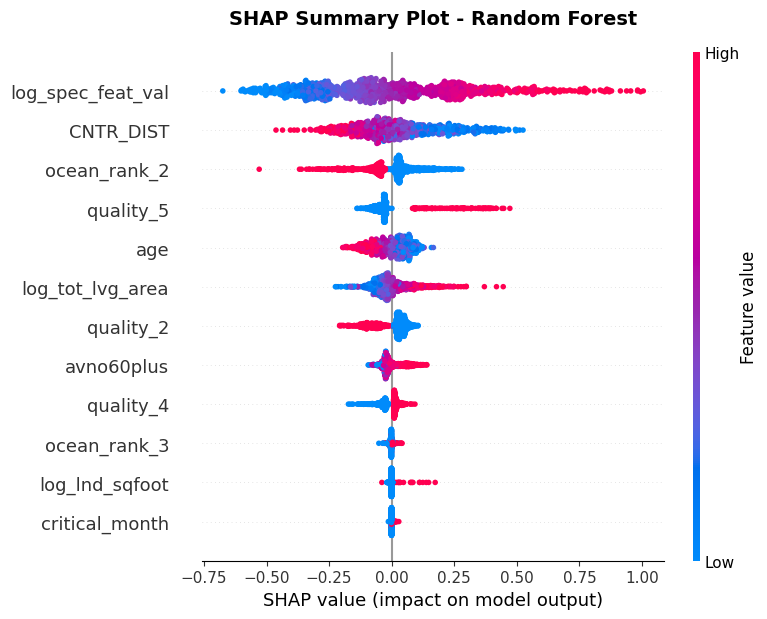

In [21]:
# Criar Summary Plot
plt.figure(figsize=(10, 8))

shap.summary_plot(
    shap_values, 
    X_test_sample,
    feature_names=all_feature_names,
    max_display=20,  # Mostrar top 20 features
    show=False
)

plt.title('SHAP Summary Plot - Random Forest', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()